In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# RetNet

[Paper](https://arxiv.org/abs/2307.08621)

RetNet is a variant around Linear Attention models. Linear Attention removes the softmax from the classic attention formula:
$$O = (Q K^{T}) V$$
This has the effect that the computation can be re-expressed recurrently as
$$S_{t} = S_{t-1} + k_{t}^{T} v_{t}$$
$$y_{t} = q_{t} S_{t}$$

RetNet changes this linear attention formula by adding a decay term to the state:
$$S_{t} = \gamma S_{t-1} + k_{t}^{T} v_{t}$$

And then when computing the output, they scale the hidden state by $\sqrt{1 + \gamma + \gamma^{2} + \cdots + \gamma^{t}}$:
$$s_{t} = 1 + \gamma s_{t-1}$$
$$y_{t} = q_{t} @ S_{t} / \sqrt{s_{t}}$$

In terms of shape, $\gamma$ is different for each head of the RetNet block, so we have:
- $q_{t}$ -> `[batch_size, num_heads, head_size]`
- $k_{t}$ -> `[batch_size, num_heads, head_size]`
- $v_{t}$ -> `[batch_size, num_heads, head_size]`
- $S_{t}$ -> `[batch_size, num_heads, head_size, head_size]`
- $\gamma$ -> `[num_heads]`
- $s_{t}$ -> `[num_heads]`
- $y_{t}$ -> `[batch_size, num_heads, head_size]`.

The product between $q_{t}$ and $S_{t}$ is a matrix product as we accumulate over one of the `head_size` dimension in the state. All the other products are elementwise.

In code, the first equation would look like:
```py
kv_outer_prod = k_rope.unsqueeze(-1) * v_heads.unsqueeze(-2)
new_recurrent_state = recurrent_state * decay[None, :, None, None] + kv_outer_prod
```
The second one:
```py
new_scales = scales * self.decay + 1.0
scale_factor = (1.0 / new_scales.sqrt())[:, :, None, None]
scaled_state = new_recurrent_state * scale_factor
out = torch.einsum("bnh,bnhk->bnk", q_rope.unsqueeze(2), scaled_state)
```

Like in a Transformer block, $q$, $k$ and $v$ are computed from the inputs using a linear projection. The $\gamma$ factor is a model parameter.

The last piece needed to write the RetNet block is Rotary Positional Embedding (rope for short). The idea is to rotate the $q$ and $k$ depending on the position in the sentence, specifically rotate $q_{t}$ and $k_{t}$ by $\theta t$. In the original attention $QK^{T}$ product, it means the comparison of $q_{t_{1}}$ with $k_{t_{2}}$ will have been "rotated" by $\theta (t_{1} - t_{2})$ so we directly add some information of how far away the timestamps $t_{1}$ and $t_{2}$ are from each other.

In practice, the rotation is done between `x1 = x[..., ::2]` and `x2 = x[..., 1::2]`. The rotation by an angle $k\theta$ is:
$$(x1 \cos(k\theta) - x2\sin(k\theta), x1 \sin(k\theta) + x2\cos(k\theta))$$

In code this is usually done with
```py
x_rope = x * cos + rotate_every_two(x) * sin
```
where we define the following function to rotate:

In [27]:
def rotate_every_two(x: torch.Tensor) -> torch.Tensor:
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    x_rot = torch.stack((-x2, x1), dim=-1).flatten(-2)
    return x_rot

In practice, the angle $\theta$ is a model parameter (with one value per `head_size`) and we need to keep track of the position with a hidden state: we start at position 0 and we increment it by one every time we do an inference:

In [30]:
batch_size = 32
num_heads = 8
head_size = 64
x = torch.randn(batch_size, num_heads, head_size)
# Let's pretend we are in this initial state
seq_offsets = torch.arange(32)
angle = torch.randn(head_size)

sin = torch.sin(seq_offsets[:, None, None] * angle[None, None, :])
cos = torch.cos(seq_offsets[:, None, None] * angle[None, None, :])

x_rope = x * cos + rotate_every_two(x) * sin

new_seq_offsets = seq_offsets + 1

This what the full RetNet model looks like, with the Retention block being the computation explained at the top of the notebook:
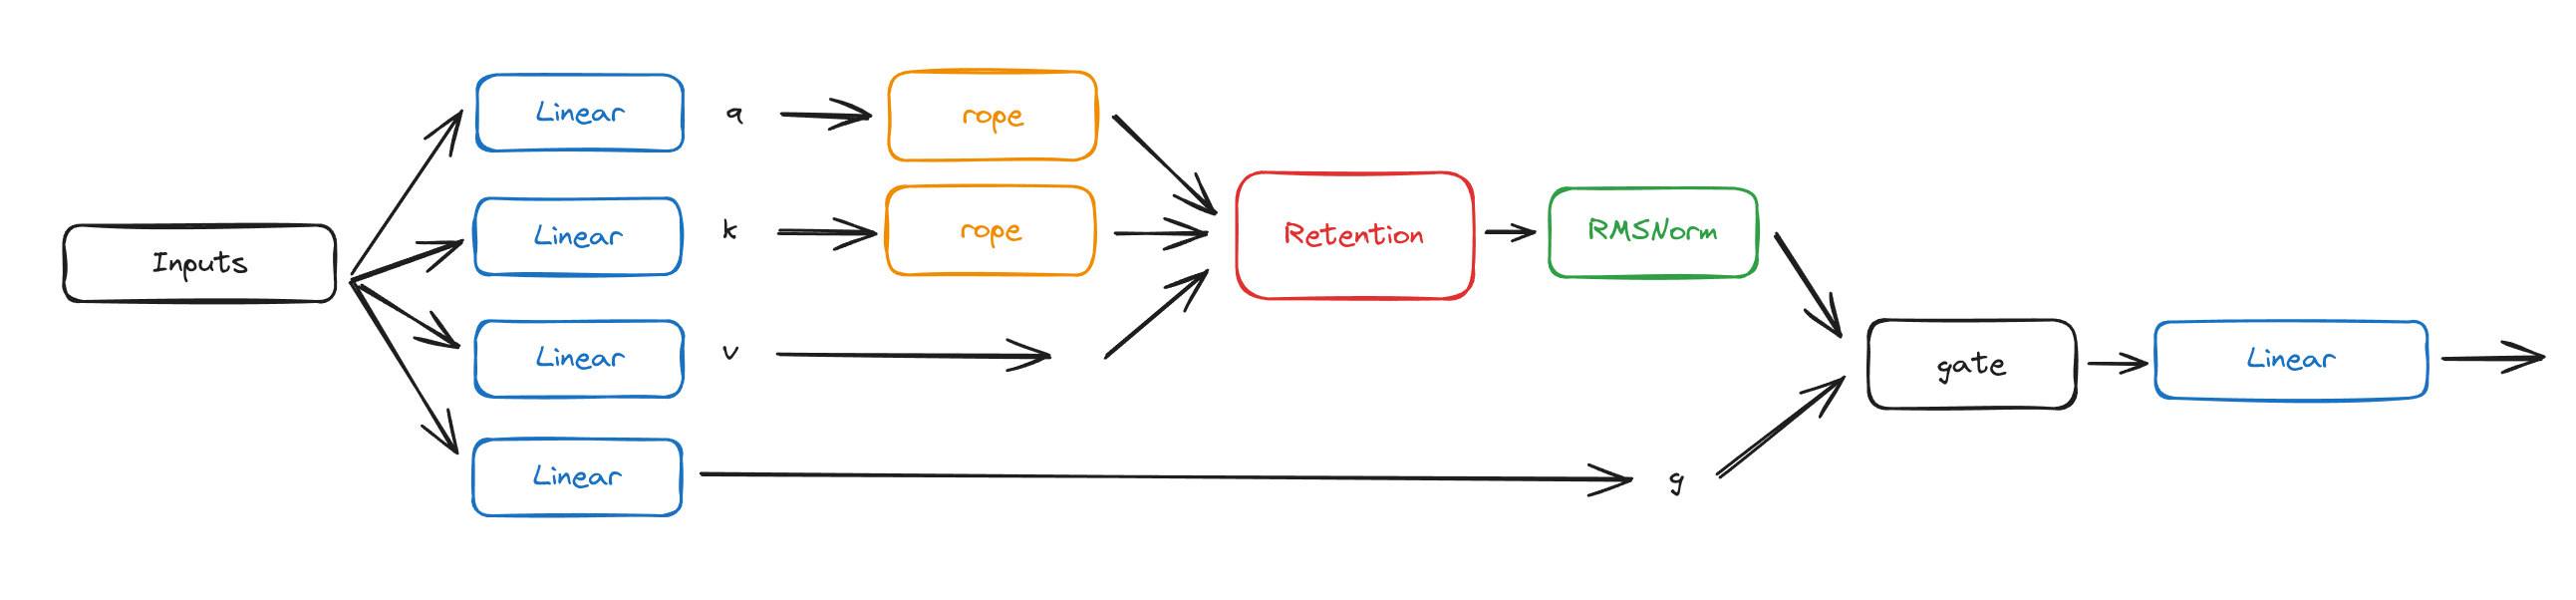

In [2]:
def get_model_device(model):
    return next(iter(model.parameters())).device

In [31]:
class RetNet(nn.Module):
    decay: torch.Tensor
    angle: torch.Tensor

    def __init__(self, hidden_size, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_size = hidden_size // num_heads
        self.scaling = self.head_size**-0.5

        self.q_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.k_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.v_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.g_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.out_proj = nn.Linear(hidden_size, hidden_size, bias=False)

        self.norm = nn.RMSNorm(self.head_size, eps=1e-6, elementwise_affine=False)

        self.register_buffer("decay", torch.empty(num_heads))
        self.register_buffer("angle", torch.empty(self.head_size))

    def forward(
        self, x: torch.Tensor, state: tuple[torch.Tensor, torch.Tensor, torch.Tensor]
    ) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
        batch_size, hidden_size = x.shape
        assert hidden_size == self.hidden_size

        seq_offsets, scales, recurrent_state = state
        assert seq_offsets.shape == (batch_size,)
        assert scales.shape == (batch_size, self.num_heads)
        assert recurrent_state.shape == (
            batch_size,
            self.num_heads,
            self.head_size,
            self.head_size,
        )

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        g = self.g_proj(x)

        k = k * self.scaling

        q_heads = q.view(batch_size, self.num_heads, self.head_size)
        k_heads = k.view(batch_size, self.num_heads, self.head_size)
        v_heads = v.view(batch_size, self.num_heads, self.head_size)

        # Rope
        sin = torch.sin(seq_offsets[:, None, None] * self.angle[None, None, :])
        cos = torch.cos(seq_offsets[:, None, None] * self.angle[None, None, :])

        q_rope = q_heads * cos + rotate_every_two(q_heads) * sin
        k_rope = k_heads * cos + rotate_every_two(k_heads) * sin

        # State update
        kv_outer_prod = k_rope.unsqueeze(-1) * v_heads.unsqueeze(-2)
        new_recurrent_state = (
            recurrent_state * self.decay[None, :, None, None] + kv_outer_prod
        )

        # State scaling
        new_scales = scales * self.decay + 1.0
        scale_factor = (1.0 / new_scales.sqrt())[:, :, None, None]
        scaled_state = new_recurrent_state * scale_factor

        # Out
        out = torch.matmul(q_rope.unsqueeze(2), scaled_state).squeeze(2)
        out = self.norm(out).reshape(batch_size, self.hidden_size)
        out = F.silu(g) * out
        out = self.out_proj(out)
        return out, (seq_offsets + 1, new_scales, new_recurrent_state)

    def init_state(
        self, batch_size: int, device: torch.device | None = None
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if device is None:
            device = get_model_device(self)
        return (
            torch.zeros(batch_size, dtype=torch.int32, device=device),
            torch.zeros(batch_size, self.num_heads, device=device),
            torch.zeros(
                batch_size,
                self.num_heads,
                self.head_size,
                self.head_size,
                device=device,
            ),
        )